## 1. Import Libraries and Load Data

First, let's import what we need and prepare the data (building on Exercise 2).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.9.1


In [2]:
# Load MNIST data (same as Exercise 2)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='../data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 60000
Test samples: 10000


## 2. Understanding the Network Architecture

We'll build a simple **feedforward neural network** with:
- **Input layer**: 28×28 = 784 pixels (flattened)
- **Hidden layer 1**: 128 neurons with ReLU activation
- **Hidden layer 2**: 64 neurons with ReLU activation
- **Output layer**: 10 neurons (one for each digit 0-9)

```
Input (784) → Dense(128) → ReLU → Dense(64) → ReLU → Dense(10) → Output
```

## 3. Define the Neural Network Class

In PyTorch, we create neural networks by inheriting from `nn.Module`.

In [3]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        
        # Define the layers
        self.fc1 = nn.Linear(28 * 28, 128)  # Input layer to hidden layer 1
        self.fc2 = nn.Linear(128, 64)        # Hidden layer 1 to hidden layer 2
        self.fc3 = nn.Linear(64, 10)         # Hidden layer 2 to output layer
        
    def forward(self, x):
        # Flatten the input (batch_size, 1, 28, 28) -> (batch_size, 784)
        x = x.view(-1, 28 * 28)
        
        # Pass through the network
        x = F.relu(self.fc1(x))  # First hidden layer with ReLU activation
        x = F.relu(self.fc2(x))  # Second hidden layer with ReLU activation
        x = self.fc3(x)          # Output layer (no activation here - will use softmax in loss)
        
        return x

print("Neural network class defined!")

Neural network class defined!


## 4. Create an Instance of the Model

In [4]:
# Create the model
model = SimpleNN()

print("Model created!")
print(model)

Model created!
SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


## 5. Examine the Model Architecture

Let's understand what's inside our model.

In [5]:
# Print detailed layer information
print("Model Architecture:")
print("=" * 70)

for name, layer in model.named_children():
    print(f"\n{name}:")
    print(f"  Type: {type(layer).__name__}")
    if hasattr(layer, 'in_features'):
        print(f"  Input features: {layer.in_features}")
        print(f"  Output features: {layer.out_features}")
        print(f"  Parameters: {layer.in_features * layer.out_features + layer.out_features:,}")

Model Architecture:

fc1:
  Type: Linear
  Input features: 784
  Output features: 128
  Parameters: 100,480

fc2:
  Type: Linear
  Input features: 128
  Output features: 64
  Parameters: 8,256

fc3:
  Type: Linear
  Input features: 64
  Output features: 10
  Parameters: 650


## 6. Count Model Parameters

Let's see how many trainable parameters our model has.

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total trainable parameters: {total_params:,}")

# Break down by layer
print("\nParameters by layer:")
for name, param in model.named_parameters():
    print(f"  {name:10s}: {param.numel():7,} parameters, shape: {list(param.shape)}")

Total trainable parameters: 109,386

Parameters by layer:
  fc1.weight: 100,352 parameters, shape: [128, 784]
  fc1.bias  :     128 parameters, shape: [128]
  fc2.weight:   8,192 parameters, shape: [64, 128]
  fc2.bias  :      64 parameters, shape: [64]
  fc3.weight:     640 parameters, shape: [10, 64]
  fc3.bias  :      10 parameters, shape: [10]


## 7. Test the Forward Pass

Let's verify that our model can process a batch of images.

In [7]:
# Get a batch of images
batch_images, batch_labels = next(iter(train_loader))

print(f"Input shape: {batch_images.shape}")

# Pass through the model
with torch.no_grad():  # No gradient computation needed for testing
    output = model(batch_images)

print(f"Output shape: {output.shape}")
print(f"\nOutput breakdown:")
print(f"  - Batch size: {output.shape[0]}")
print(f"  - Number of classes: {output.shape[1]}")

Input shape: torch.Size([64, 1, 28, 28])
Output shape: torch.Size([64, 10])

Output breakdown:
  - Batch size: 64
  - Number of classes: 10


## 8. Examine Model Predictions (Untrained)

Let's see what the untrained model predicts. It should be random!

In [8]:
# Look at outputs for the first image
print("Raw output scores for first image:")
print(output[0])

# Apply softmax to get probabilities
probabilities = F.softmax(output[0], dim=0)
print("\nProbabilities (should be roughly uniform for untrained model):")
for i, prob in enumerate(probabilities):
    print(f"  Digit {i}: {prob.item():.3f} ({prob.item()*100:.1f}%)")

# Get prediction
predicted_digit = output[0].argmax().item()
actual_digit = batch_labels[0].item()

print(f"\nPredicted digit: {predicted_digit}")
print(f"Actual digit: {actual_digit}")
print(f"Correct: {predicted_digit == actual_digit}")

Raw output scores for first image:
tensor([ 0.0361, -0.0586,  0.2107,  0.1575,  0.0203,  0.0732,  0.1394, -0.0832,
        -0.1501, -0.1047])

Probabilities (should be roughly uniform for untrained model):
  Digit 0: 0.101 (10.1%)
  Digit 1: 0.091 (9.1%)
  Digit 2: 0.120 (12.0%)
  Digit 3: 0.114 (11.4%)
  Digit 4: 0.099 (9.9%)
  Digit 5: 0.104 (10.4%)
  Digit 6: 0.111 (11.1%)
  Digit 7: 0.089 (8.9%)
  Digit 8: 0.083 (8.3%)
  Digit 9: 0.087 (8.7%)

Predicted digit: 2
Actual digit: 6
Correct: False


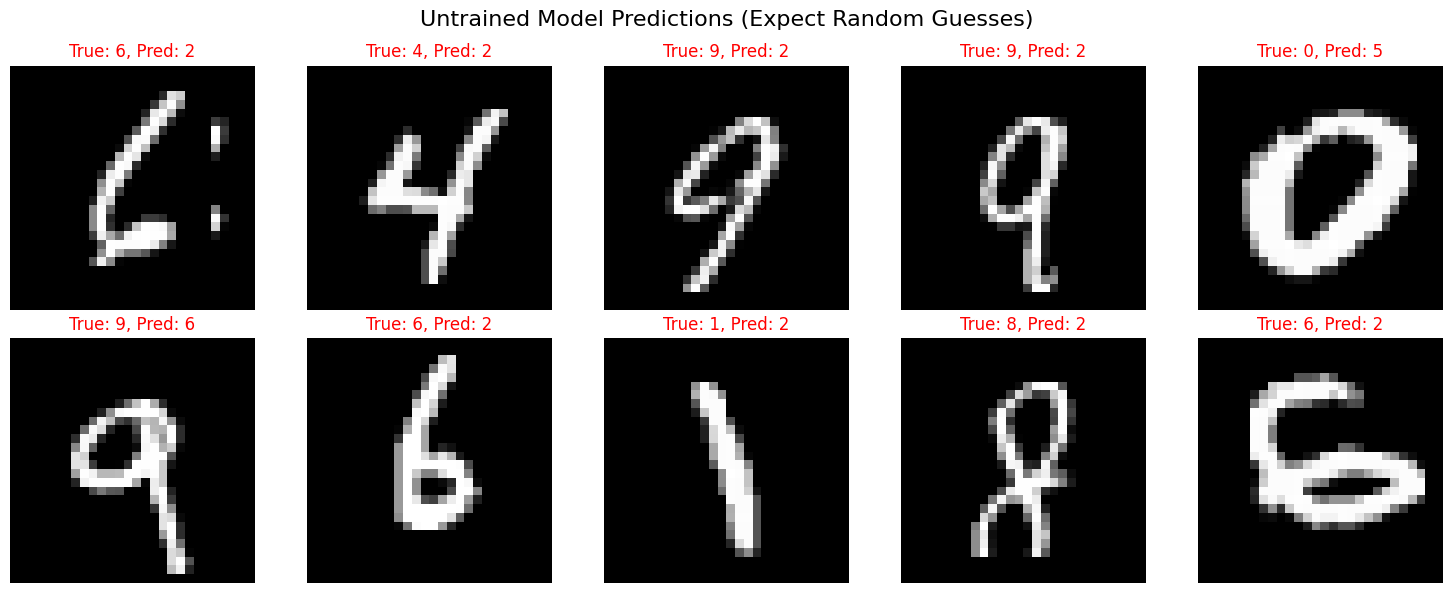


Accuracy on these 10 samples: 0/10 = 0%
(Random guessing would be ~10% accuracy)


In [9]:
# Visualize some predictions from the untrained model
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Untrained Model Predictions (Expect Random Guesses)', fontsize=16)

with torch.no_grad():
    predictions = model(batch_images[:10])
    predicted_labels = predictions.argmax(dim=1)

for i, ax in enumerate(axes.flat):
    image = batch_images[i].squeeze().numpy()
    true_label = batch_labels[i].item()
    pred_label = predicted_labels[i].item()
    
    ax.imshow(image, cmap='gray')
    
    # Color: green if correct, red if wrong
    color = 'green' if pred_label == true_label else 'red'
    ax.set_title(f"True: {true_label}, Pred: {pred_label}", color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Calculate accuracy on this batch
correct = (predicted_labels[:10] == batch_labels[:10]).sum().item()
print(f"\nAccuracy on these 10 samples: {correct}/10 = {correct*10}%")
print("(Random guessing would be ~10% accuracy)")

## 9. Understanding Activation Functions

Let's visualize what ReLU (Rectified Linear Unit) does.

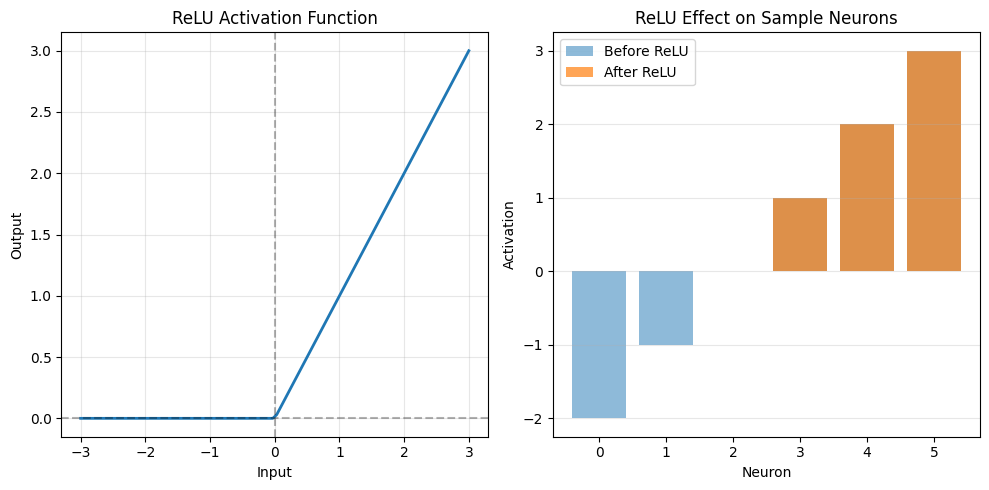


ReLU: Keeps positive values, sets negative values to zero
This introduces non-linearity, allowing the network to learn complex patterns!


In [10]:
# Create sample data
x = torch.linspace(-3, 3, 100)

# Apply ReLU
y_relu = F.relu(x)

# Plot
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(x.numpy(), y_relu.numpy(), linewidth=2)
plt.grid(True, alpha=0.3)
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('ReLU Activation Function')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)

# Show the effect on actual neuron outputs
plt.subplot(1, 2, 2)
sample_values = torch.tensor([-2, -1, 0, 1, 2, 3])
plt.bar(range(len(sample_values)), sample_values.numpy(), alpha=0.5, label='Before ReLU')
plt.bar(range(len(sample_values)), F.relu(sample_values).numpy(), alpha=0.7, label='After ReLU')
plt.xlabel('Neuron')
plt.ylabel('Activation')
plt.title('ReLU Effect on Sample Neurons')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nReLU: Keeps positive values, sets negative values to zero")
print("This introduces non-linearity, allowing the network to learn complex patterns!")

## 10. Move Model to Device (CPU/GPU)

Let's prepare the model to use GPU if available.

In [11]:
# Determine device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon GPU (MPS)")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Move model to device
model = model.to(device)
print(f"\nModel moved to: {device}")

Using Apple Silicon GPU (MPS)

Model moved to: mps


## 11. Summary

Congratulations! You've completed Exercise 3. You now know:

✅ How to define a neural network class in PyTorch

✅ How to create layers (Linear) and activation functions (ReLU)

✅ How to implement the forward pass

✅ How to examine model architecture and count parameters

✅ How to test the model with a forward pass

✅ What an untrained model's predictions look like (random!)

✅ How activation functions introduce non-linearity

✅ How to move the model to GPU/CPU

### Key Takeaways

- **Architecture**: Input (784) → Dense(128) → ReLU → Dense(64) → ReLU → Dense(10)
- **Parameters**: ~110K trainable parameters
- **Untrained model**: Makes random predictions (~10% accuracy)
- **ReLU**: Critical for learning complex patterns by introducing non-linearity

### Next Steps

In Exercise 4, we'll train this model and watch it learn to recognize digits!